In [4]:
import joblib
import pyproj
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

%matplotlib inline
%config IPCompleter.use_jedi = False

In [5]:
df_hist = pd.read_parquet('../data/processed/HistoricoVentas.parquet', engine='pyarrow')
print(df_hist.shape)

df_total_skus = df_hist.groupby('SKU', as_index=False).Hectolitros.sum().sort_values('Hectolitros')
skus_cero = df_total_skus[df_total_skus.Hectolitros == 0].SKU.unique()

df_hist_filtrado = df_hist.loc[~df_hist.SKU.isin(skus_cero)]
print(df_hist_filtrado.shape)
df_hist_filtrado.head()

(554466, 4)
(352780, 4)


,Mes,Subagencia,SKU,Hectolitros
0,2013-01-01,10197,00000001,48.028901
1,2013-01-01,10203,00000001,2.524817
2,2013-01-01,10198,00000001,3.500314
3,2013-01-01,10204,00000001,8.549948
4,2013-01-01,10199,00000001,6.484189


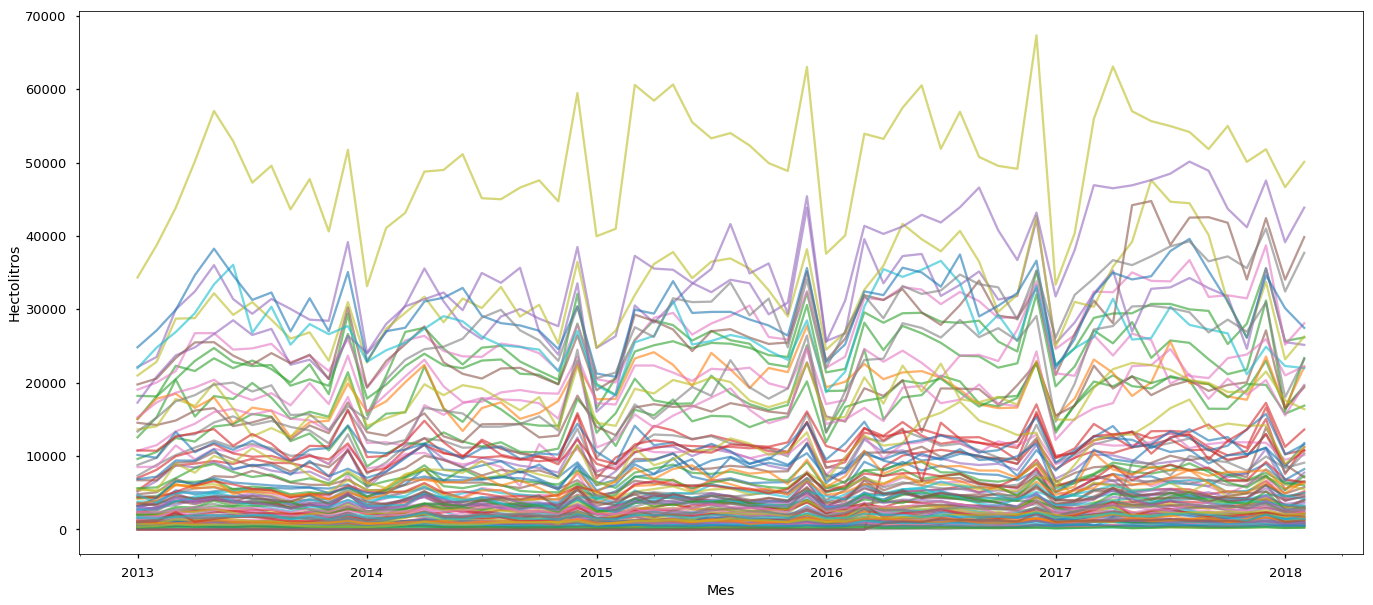

In [3]:
df_junto = df_hist_filtrado.groupby(['Mes', 'Subagencia'], as_index=False).Hectolitros.sum().sort_values('Mes')

with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(1, 1, figsize=(23, 10))
    df_test = df_junto.pivot(index='Mes', columns='Subagencia', values='Hectolitros')
    df_test.plot(legend=False, alpha=0.6, ax=ax)
    ax.set_ylabel('Hectolitros')

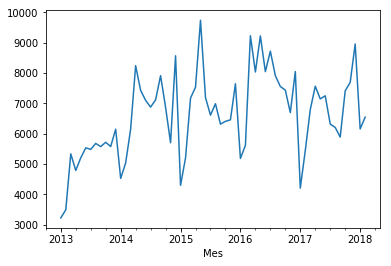

In [17]:
df_test['10003'].plot()

In [23]:
from fbprophet import Prophet

In [45]:
df_ts = df_test[['10003']].reset_index().rename(columns={'Mes': 'ds', '10003': 'y'})
# df_ts = df_ts.assign(y=np.log(df_ts.y + 1))
m = Prophet()
m.fit(df_ts);

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/raul/miniconda3/envs/modelo/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [46]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

/home/raul/miniconda3/envs/modelo/lib/python3.6/site-packages/fbprophet/forecaster.py:1010: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = seasonal_features.as_matrix()
/home/raul/miniconda3/envs/modelo/lib/python3.6/site-packages/fbprophet/forecaster.py:1134: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  seasonal = np.matmul(seasonal_features.as_matrix(), beta) * self.y_scale


,ds,yhat,yhat_lower,yhat_upper
422,2019-01-28,6595.922837,5644.052757,7534.430913
423,2019-01-29,6545.271559,5554.257002,7541.273190
424,2019-01-30,6495.542454,5552.761889,7447.597780
425,2019-01-31,6448.209670,5538.048696,7455.723752
426,2019-02-01,6404.679316,5492.235518,7390.804566


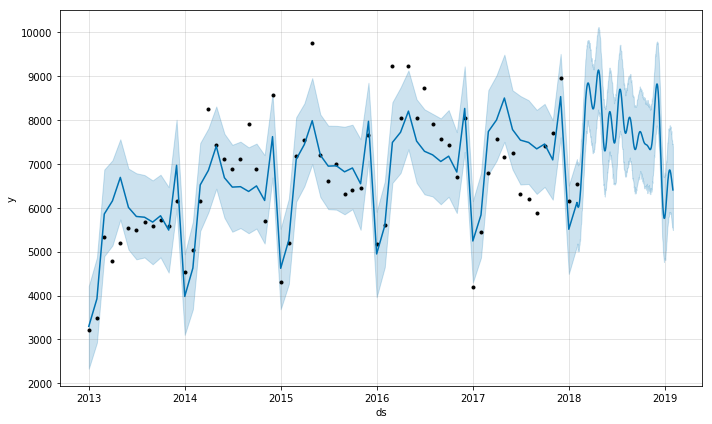

In [47]:
m.plot(forecast);

/home/raul/miniconda3/envs/modelo/lib/python3.6/site-packages/fbprophet/forecaster.py:1010: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = seasonal_features.as_matrix()


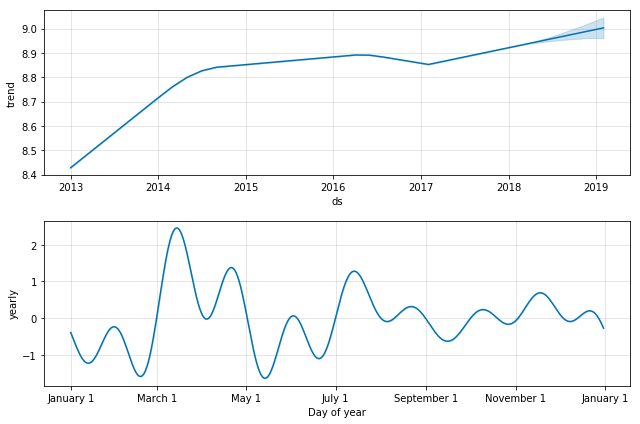

In [44]:
m.plot_components(forecast);

In [37]:
m.plot_components??

Signature: m.plot_components(fcst, uncertainty=True, plot_cap=True, weekly_start=0, yearly_start=0)
Source:   
    def plot_components(self, fcst, uncertainty=True, plot_cap=True,
                        weekly_start=0, yearly_start=0):
        """Plot the Prophet forecast components.

        Will plot whichever are available of: trend, holidays, weekly
        seasonality, and yearly seasonality.

        Parameters
        ----------
        fcst: pd.DataFrame output of self.predict.
        uncertainty: Optional boolean to plot uncertainty intervals.
        plot_cap: Optional boolean indicating if the capacity should be shown
            in the figure, if available.
        weekly_start: Optional int specifying the start day of the weekly
            seasonality plot. 0 (default) starts the week on Sunday. 1 shifts
            by 1 day to Monday, and so on.
        yearly_start: Optional int specifying the start day of the yearly
            seasonality plot. 0 (default) starts th

In [38]:
m.plot_forecast_component??

Signature: m.plot_forecast_component(fcst, name, ax=None, uncertainty=True, plot_cap=False)
Source:   
    def plot_forecast_component(
            self, fcst, name, ax=None, uncertainty=True, plot_cap=False):
        """Plot a particular component of the forecast.

        Parameters
        ----------
        fcst: pd.DataFrame output of self.predict.
        name: Name of the component to plot.
        ax: Optional matplotlib Axes to plot on.
        uncertainty: Optional boolean to plot uncertainty intervals.
        plot_cap: Optional boolean indicating if the capacity should be shown
            in the figure, if available.

        Returns
        -------
        a list of matplotlib artists
        """
        artists = []
        if not ax:
            fig = plt.figure(facecolor='w', figsize=(10, 6))
            ax = fig.add_subplot(111)
        fcst_t = fcst['ds'].dt.to_pydatetime()
        artists += ax.plot(fcst_t, fcst[name], ls='-', c='#0072B2')
        if 'cap' in fcst a